This is a data analysis of Reddit posts pertaining to the effects of AI on the job market. We start by importing the libraries that we will need.

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from collections import Counter 

Next, we import our dataset into Pandas for processing.

In [5]:
df = pd.read_csv('ai_automation_job_market_data200_edit.csv', encoding='latin1')

pd.set_option('display.max_columns', None) # Avoid truncation

Now it's time for initial data exploration

In [7]:
df

,Title,Selftext,Score,Number of Comments,Created UTC,Unnamed: 5
0,CMV: People who think that most jobs are going...,I have been lucky enough to have a career path...,705,511.0,1.708275e+09,NaN
1,Is this the last presidential election in US h...,[Uber is partnering with Chinese firm BYD to b...,406,230.0,1.727364e+09,NaN
2,What will the stock market do if ai creates gr...,I know nobody has a crystal ball and no one ca...,36,166.0,1.726364e+09,NaN
3,"I'm Nick Kolakowski, Senior Editor at Dice. AM...","Hi! I?æª Nick Kolakowski, the Senior Editor o...",102,143.0,1.718886e+09,NaN
4,The Elephant In the Room with AI art and AI Au...,"\n\nAs I see it, the main issue with AI art a...",165,334.0,1.672166e+09,NaN
...,...,...,...,...,...,...
173,What does the future of our work look like in ...,I'm sure we've all been thinking a lot lately ...,18,79.0,1.728255e+09,NaN
174,"Blackmen, is this dystopian reality possible?",Is this dystopian reality possible?\n\n\t??Mas...,10,42.0,1.739900e+09,NaN
175,Learnings from my Experience in USA: [BTech ->...,**TLDR:**\n\n1. US immigration and job landsca...,128,40.0,1.733100e+09,NaN
176,The 15 Best (Free to Use) AI Tools for Creatin...,While we wait for ChatGPT to roll out its own ...,458,64.0,1.695663e+09,NaN


The first thing we notice is there's an unnecessary column with NaN (non-numerical, invalid) values. In addition, the timestamp column in UTC isn't in an easily human-readable format, so it needs to be displayed as a human-readable date even though UTC is easier to use for data processing.

In [9]:
df = df.drop('Unnamed: 5', axis=1)

In [10]:
df

,Title,Selftext,Score,Number of Comments,Created UTC
0,CMV: People who think that most jobs are going...,I have been lucky enough to have a career path...,705,511.0,1.708275e+09
1,Is this the last presidential election in US h...,[Uber is partnering with Chinese firm BYD to b...,406,230.0,1.727364e+09
2,What will the stock market do if ai creates gr...,I know nobody has a crystal ball and no one ca...,36,166.0,1.726364e+09
3,"I'm Nick Kolakowski, Senior Editor at Dice. AM...","Hi! I?æª Nick Kolakowski, the Senior Editor o...",102,143.0,1.718886e+09
4,The Elephant In the Room with AI art and AI Au...,"\n\nAs I see it, the main issue with AI art a...",165,334.0,1.672166e+09
...,...,...,...,...,...
173,What does the future of our work look like in ...,I'm sure we've all been thinking a lot lately ...,18,79.0,1.728255e+09
174,"Blackmen, is this dystopian reality possible?",Is this dystopian reality possible?\n\n\t??Mas...,10,42.0,1.739900e+09
175,Learnings from my Experience in USA: [BTech ->...,**TLDR:**\n\n1. US immigration and job landsca...,128,40.0,1.733100e+09
176,The 15 Best (Free to Use) AI Tools for Creatin...,While we wait for ChatGPT to roll out its own ...,458,64.0,1.695663e+09


Having cleaned our dataset, the next thing to do is check the frequency of specific key terms in our post data, both the titles and main text. We will load our terms from an external file to make this easier to maintain.

Example reference: [GeeksForGeeks Python Read Text File into List or Array - Using List Comprehension](https://www.geeksforgeeks.org/python-read-text-file-into-list-or-array/#using-list-comprehension) for guidance on loading lines from an external text file.

In [12]:
key_terms=[]

with open('terms.txt', 'r') as file:
    key_terms = [line.strip() for line in file]
    key_terms = [s.lower() for s in key_terms]

print(key_terms)

['ai', 'artificial intelligence', 'llm', 'automation', 'impact', 'unemployment', 'risk', 'loss', 'layoff', 'fired', 'redundant', 'struggling', 'obsolete', 'retrain', 'stress', 'concerned', 'scared', 'frustrated', 'hopeless', 'overwhelmed']


This function is completely hand-written, because an attempt to use [Anaconda Assistant](https://www.anaconda.com/capability/anaconda-assistant) to generate an example resulted in a function with too many parameters, redundant comments, and variable names that don't flow particularly well with the conventions used elsewhere in this notebook. It also turned out to be highly inefficient and thus a new approach based on the advantages of the Pandas library has been implemented. As a result, the cell with AI-generated code was removed and replaced with this hand-written function. Only the most superficial code to lower the case of all characters in a string was reused from generated code. [Anaconda Assistant](https://www.anaconda.com/capability/anaconda-assistant) has been turned off for this notebook and will not be used for anything else.

This function is to be reused for both titles and post bodies.

In [14]:
def string_frequency(column='Title'):
    strings_lower = df[column].str.lower()

    # Make sure only strings are present
    strings_lower = [s for s in strings_lower if isinstance(s, str)]

    frequencies = {}

    for idx in range(len(strings_lower)):
        split_string = strings_lower[idx].split()
        word_counts = pd.Series(split_string).value_counts()
        word_counts = word_counts[word_counts.index.isin(key_terms)]
        
        frequencies[df['Title'][idx]] = word_counts

    return pd.DataFrame.from_dict(frequencies)

Verify the columns that will have their text processed.

In [16]:
df["Title"]

0      CMV: People who think that most jobs are going...
1      Is this the last presidential election in US h...
2      What will the stock market do if ai creates gr...
3      I'm Nick Kolakowski, Senior Editor at Dice. AM...
4      The Elephant In the Room with AI art and AI Au...
                             ...                        
173    What does the future of our work look like in ...
174        Blackmen, is this dystopian reality possible?
175    Learnings from my Experience in USA: [BTech ->...
176    The 15 Best (Free to Use) AI Tools for Creatin...
177                     Been Unemployed for 1 Year! ?æ§
Name: Title, Length: 178, dtype: object

In [17]:
df["Selftext"]

0      I have been lucky enough to have a career path...
1      [Uber is partnering with Chinese firm BYD to b...
2      I know nobody has a crystal ball and no one ca...
3      Hi! I?æª Nick Kolakowski, the Senior Editor o...
4       \n\nAs I see it, the main issue with AI art a...
                             ...                        
173    I'm sure we've all been thinking a lot lately ...
174    Is this dystopian reality possible?\n\n\t??Mas...
175    **TLDR:**\n\n1. US immigration and job landsca...
176    While we wait for ChatGPT to roll out its own ...
177    It's official... I've been unemployed for 1 ye...
Name: Selftext, Length: 178, dtype: object

Here we check the frequency of key terms in post titles, saved to title_df.

In [19]:
title_df=string_frequency()

In [20]:
title_df

,CMV: People who think that most jobs are going to be replaced by AI in the next couple decades have very little understanding of how modern societies function and have a skewed view of macroeconomics.,Is this the last presidential election in US history that won't be dominated by the issue of reorganizing society as free-market human jobs disappear to automation?,What will the stock market do if ai creates growth in businesses but also makes lots of people lose their jobs due to automation?,"I'm Nick Kolakowski, Senior Editor at Dice. AMA about the tech job market, AI, and more!",The Elephant In the Room with AI art and AI Automation Generally,What will the stock market do if ai creates huge growth in corporations but also makes a lot of people lose their jobs due to automation?,"Ultimate Guide for Building a Startup with ChatGPT Prompts, from Scratch (free, no ads/sign-ups)","28, quit my job as PM to follow my dream. My plan: no more fancy SaaS. Just boring niches, hyper-automation, and $1.7k/month to stay in the game",Is this something you think about when considering FIRE? What will the stock market do if AI creates growth in corporations but also makes lots of people lose their jobs due to automation?,"Just turned 31, jobless, still living with my parents, deadline to get a job by March 1st.",My passive income streams,Just F*ck It... I will start my own company,I figured it out! Trump/Project 2025 is the distraction!! ELON MUSK IS THE ENDGAME!!!,AUTOMATICALLY APPLIED 1000 JOBS in 24h and got 50 INTERVIEWS!,"The jobs aren?æª being replaced by AI, but India","A Microsoft employee thinks there may soon be huge deflation in medical costs, as the company is close to commoditizing doctor's expertise & making it cheap and freely available.","My little brother wants to study CS because of my remote job, should I warn him?","Stellaris Big ""Dick"" 3.0 Patch Notes: What They Actually Mean","Indian Job Market is seeing a unique trend. On the employment side we often see reports about rise in unemployment, lack of quality jobs and opportunity but on the other...?",Automation and the Job Market: Threat or Opportunity?,Nokia $NOK Debunking common myths. And a look at recent news.,ROAST ME! AI CV a plugin to automate and customise your job applications. as starters we modify your cv and write you an intention letter but if market research proves us the need for the tool we would convert it into extension so that you could do +20 job applications in matter of clicks,The only way for the civilisation to keep advancing is either guaranteed basic income or genocide,This subs handwaving of automation and AIs effect on the job market is delusion,"""Workers are hiding their AI productivity hacks from bosses""","Blog post ""Plentiful, high-paying jobs in the age of AI"" by Noah Smith, ""a guy who writes about economics."" The topic is the possibility that jobs for humans will be plentiful and high-paying even if AI is someday better than humans at every task because of the principle of comparative advantage",They need us to start getting nasty,CNBC: ChatGPT is already generating savings for companies for coding and to write job descriptions.,What will happen to the stock market if ai creates huge growth in corporations but also makes lots of people lose their jobs due to the automation?,My Husband Wants to Start a Startup in a Few Months ?æ'm pretty worried. What should I expect? I will not promote,GIM WAT TOPICS (will keep updating the list),Indian CIOs to Start Budgeting for GenAI in 2025 ??How Will This Impact the IT Job Market?,"Synopsis: Evergrande, å°rypto and Gamestop links to the financial crash that?æª afoot.",I run an AI automation agency (AAA). My honest overview and review of this new business model,Civil Engineering is a great (and underrated) way to get into the middle class,How AI is Changing the Job Market and Business,How do you feel about the rise of AI and automation in the workforce?,What will the stock market do if AI 

Here we check the frequency of key terms in post bodies, saved to title_df. They are still keyed to titles for brevity's sake, but we are counting frequency in post bodies.

In [22]:
selftext_df=string_frequency('Selftext')

In [23]:
display(selftext_df)

,CMV: People who think that most jobs are going to be replaced by AI in the next couple decades have very little understanding of how modern societies function and have a skewed view of macroeconomics.,Is this the last presidential election in US history that won't be dominated by the issue of reorganizing society as free-market human jobs disappear to automation?,What will the stock market do if ai creates growth in businesses but also makes lots of people lose their jobs due to automation?,"I'm Nick Kolakowski, Senior Editor at Dice. AMA about the tech job market, AI, and more!",The Elephant In the Room with AI art and AI Automation Generally,What will the stock market do if ai creates huge growth in corporations but also makes a lot of people lose their jobs due to automation?,"Ultimate Guide for Building a Startup with ChatGPT Prompts, from Scratch (free, no ads/sign-ups)","28, quit my job as PM to follow my dream. My plan: no more fancy SaaS. Just boring niches, hyper-automation, and $1.7k/month to stay in the game",Is this something you think about when considering FIRE? What will the stock market do if AI creates growth in corporations but also makes lots of people lose their jobs due to automation?,"Just turned 31, jobless, still living with my parents, deadline to get a job by March 1st.",My passive income streams,Just F*ck It... I will start my own company,I figured it out! Trump/Project 2025 is the distraction!! ELON MUSK IS THE ENDGAME!!!,AUTOMATICALLY APPLIED 1000 JOBS in 24h and got 50 INTERVIEWS!,"The jobs aren?æª being replaced by AI, but India","A Microsoft employee thinks there may soon be huge deflation in medical costs, as the company is close to commoditizing doctor's expertise & making it cheap and freely available.","My little brother wants to study CS because of my remote job, should I warn him?","Stellaris Big ""Dick"" 3.0 Patch Notes: What They Actually Mean","Indian Job Market is seeing a unique trend. On the employment side we often see reports about rise in unemployment, lack of quality jobs and opportunity but on the other...?",Automation and the Job Market: Threat or Opportunity?,Nokia $NOK Debunking common myths. And a look at recent news.,ROAST ME! AI CV a plugin to automate and customise your job applications. as starters we modify your cv and write you an intention letter but if market research proves us the need for the tool we would convert it into extension so that you could do +20 job applications in matter of clicks,The only way for the civilisation to keep advancing is either guaranteed basic income or genocide,This subs handwaving of automation and AIs effect on the job market is delusion,"""Workers are hiding their AI productivity hacks from bosses""","Blog post ""Plentiful, high-paying jobs in the age of AI"" by Noah Smith, ""a guy who writes about economics."" The topic is the possibility that jobs for humans will be plentiful and high-paying even if AI is someday better than humans at every task because of the principle of comparative advantage",They need us to start getting nasty,CNBC: ChatGPT is already generating savings for companies for coding and to write job descriptions.,What will happen to the stock market if ai creates huge growth in corporations but also makes lots of people lose their jobs due to the automation?,My Husband Wants to Start a Startup in a Few Months ?æ'm pretty worried. What should I expect? I will not promote,GIM WAT TOPICS (will keep updating the list),Indian CIOs to Start Budgeting for GenAI in 2025 ??How Will This Impact the IT Job Market?,"Synopsis: Evergrande, å°rypto and Gamestop links to the financial crash that?æª afoot.",I run an AI automation agency (AAA). My honest overview and review of this new business model,Civil Engineering is a great (and underrated) way to get into the middle class,How AI is Changing the Job Market and Business,How do you feel about the rise of AI and automation in the workforce?,What will the stock market do if AI 

Our raw dataframes show NaN values where a key term doesn't show up, so we should impute 0 into them.

In [25]:
title_df=title_df.fillna(0)

In [26]:
title_df

,CMV: People who think that most jobs are going to be replaced by AI in the next couple decades have very little understanding of how modern societies function and have a skewed view of macroeconomics.,Is this the last presidential election in US history that won't be dominated by the issue of reorganizing society as free-market human jobs disappear to automation?,What will the stock market do if ai creates growth in businesses but also makes lots of people lose their jobs due to automation?,"I'm Nick Kolakowski, Senior Editor at Dice. AMA about the tech job market, AI, and more!",The Elephant In the Room with AI art and AI Automation Generally,What will the stock market do if ai creates huge growth in corporations but also makes a lot of people lose their jobs due to automation?,"Ultimate Guide for Building a Startup with ChatGPT Prompts, from Scratch (free, no ads/sign-ups)","28, quit my job as PM to follow my dream. My plan: no more fancy SaaS. Just boring niches, hyper-automation, and $1.7k/month to stay in the game",Is this something you think about when considering FIRE? What will the stock market do if AI creates growth in corporations but also makes lots of people lose their jobs due to automation?,"Just turned 31, jobless, still living with my parents, deadline to get a job by March 1st.",My passive income streams,Just F*ck It... I will start my own company,I figured it out! Trump/Project 2025 is the distraction!! ELON MUSK IS THE ENDGAME!!!,AUTOMATICALLY APPLIED 1000 JOBS in 24h and got 50 INTERVIEWS!,"The jobs aren?æª being replaced by AI, but India","A Microsoft employee thinks there may soon be huge deflation in medical costs, as the company is close to commoditizing doctor's expertise & making it cheap and freely available.","My little brother wants to study CS because of my remote job, should I warn him?","Stellaris Big ""Dick"" 3.0 Patch Notes: What They Actually Mean","Indian Job Market is seeing a unique trend. On the employment side we often see reports about rise in unemployment, lack of quality jobs and opportunity but on the other...?",Automation and the Job Market: Threat or Opportunity?,Nokia $NOK Debunking common myths. And a look at recent news.,ROAST ME! AI CV a plugin to automate and customise your job applications. as starters we modify your cv and write you an intention letter but if market research proves us the need for the tool we would convert it into extension so that you could do +20 job applications in matter of clicks,The only way for the civilisation to keep advancing is either guaranteed basic income or genocide,This subs handwaving of automation and AIs effect on the job market is delusion,"""Workers are hiding their AI productivity hacks from bosses""","Blog post ""Plentiful, high-paying jobs in the age of AI"" by Noah Smith, ""a guy who writes about economics."" The topic is the possibility that jobs for humans will be plentiful and high-paying even if AI is someday better than humans at every task because of the principle of comparative advantage",They need us to start getting nasty,CNBC: ChatGPT is already generating savings for companies for coding and to write job descriptions.,What will happen to the stock market if ai creates huge growth in corporations but also makes lots of people lose their jobs due to the automation?,My Husband Wants to Start a Startup in a Few Months ?æ'm pretty worried. What should I expect? I will not promote,GIM WAT TOPICS (will keep updating the list),Indian CIOs to Start Budgeting for GenAI in 2025 ??How Will This Impact the IT Job Market?,"Synopsis: Evergrande, å°rypto and Gamestop links to the financial crash that?æª afoot.",I run an AI automation agency (AAA). My honest overview and review of this new business model,Civil Engineering is a great (and underrated) way to get into the middle class,How AI is Changing the Job Market and Business,How do you feel about the rise of AI and automation in the workforce?,What will the stock market do if AI 

In [27]:
selftext_df=selftext_df.fillna(0)

In [28]:
selftext_df

,CMV: People who think that most jobs are going to be replaced by AI in the next couple decades have very little understanding of how modern societies function and have a skewed view of macroeconomics.,Is this the last presidential election in US history that won't be dominated by the issue of reorganizing society as free-market human jobs disappear to automation?,What will the stock market do if ai creates growth in businesses but also makes lots of people lose their jobs due to automation?,"I'm Nick Kolakowski, Senior Editor at Dice. AMA about the tech job market, AI, and more!",The Elephant In the Room with AI art and AI Automation Generally,What will the stock market do if ai creates huge growth in corporations but also makes a lot of people lose their jobs due to automation?,"Ultimate Guide for Building a Startup with ChatGPT Prompts, from Scratch (free, no ads/sign-ups)","28, quit my job as PM to follow my dream. My plan: no more fancy SaaS. Just boring niches, hyper-automation, and $1.7k/month to stay in the game",Is this something you think about when considering FIRE? What will the stock market do if AI creates growth in corporations but also makes lots of people lose their jobs due to automation?,"Just turned 31, jobless, still living with my parents, deadline to get a job by March 1st.",My passive income streams,Just F*ck It... I will start my own company,I figured it out! Trump/Project 2025 is the distraction!! ELON MUSK IS THE ENDGAME!!!,AUTOMATICALLY APPLIED 1000 JOBS in 24h and got 50 INTERVIEWS!,"The jobs aren?æª being replaced by AI, but India","A Microsoft employee thinks there may soon be huge deflation in medical costs, as the company is close to commoditizing doctor's expertise & making it cheap and freely available.","My little brother wants to study CS because of my remote job, should I warn him?","Stellaris Big ""Dick"" 3.0 Patch Notes: What They Actually Mean","Indian Job Market is seeing a unique trend. On the employment side we often see reports about rise in unemployment, lack of quality jobs and opportunity but on the other...?",Automation and the Job Market: Threat or Opportunity?,Nokia $NOK Debunking common myths. And a look at recent news.,ROAST ME! AI CV a plugin to automate and customise your job applications. as starters we modify your cv and write you an intention letter but if market research proves us the need for the tool we would convert it into extension so that you could do +20 job applications in matter of clicks,The only way for the civilisation to keep advancing is either guaranteed basic income or genocide,This subs handwaving of automation and AIs effect on the job market is delusion,"""Workers are hiding their AI productivity hacks from bosses""","Blog post ""Plentiful, high-paying jobs in the age of AI"" by Noah Smith, ""a guy who writes about economics."" The topic is the possibility that jobs for humans will be plentiful and high-paying even if AI is someday better than humans at every task because of the principle of comparative advantage",They need us to start getting nasty,CNBC: ChatGPT is already generating savings for companies for coding and to write job descriptions.,What will happen to the stock market if ai creates huge growth in corporations but also makes lots of people lose their jobs due to the automation?,My Husband Wants to Start a Startup in a Few Months ?æ'm pretty worried. What should I expect? I will not promote,GIM WAT TOPICS (will keep updating the list),Indian CIOs to Start Budgeting for GenAI in 2025 ??How Will This Impact the IT Job Market?,"Synopsis: Evergrande, å°rypto and Gamestop links to the financial crash that?æª afoot.",I run an AI automation agency (AAA). My honest overview and review of this new business model,Civil Engineering is a great (and underrated) way to get into the middle class,How AI is Changing the Job Market and Business,How do you feel about the rise of AI and automation in the workforce?,What will the stock market do if AI 

Data tables can be overwhelming to read, so it's better to visualize our data. For these purposes, we will display bar graphs of the frequency of each term for each post. First, we will display a grid of graphs for each title, and then we will do the same for post bodies.

/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_tic

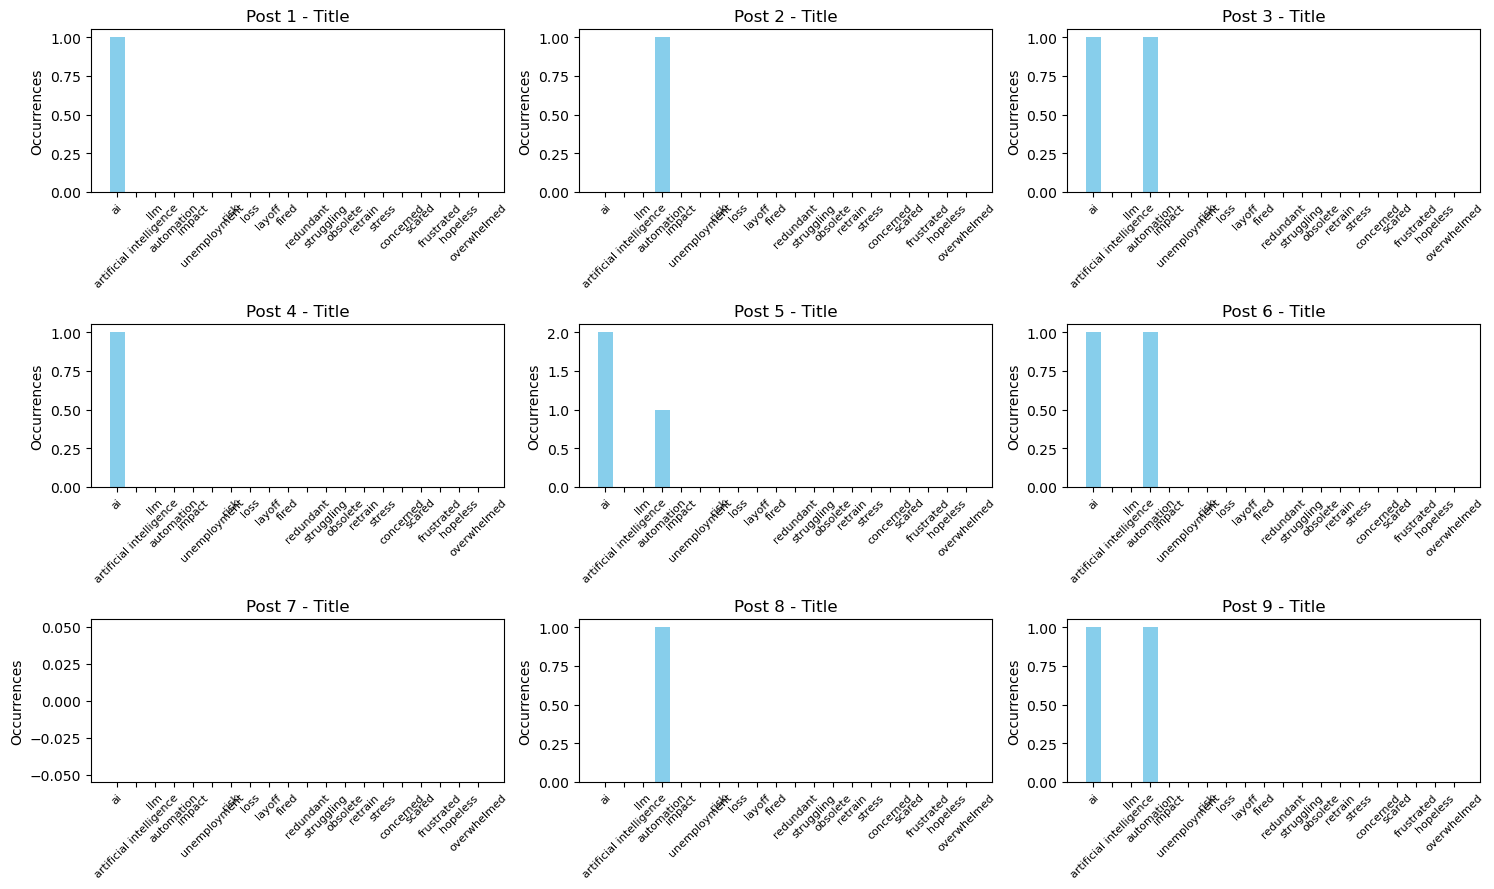

/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
/var/folders/rw/v4vq4vs13_99f9qgg71lfry00000gn/T/ipykernel_69018/4058947229.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_tic

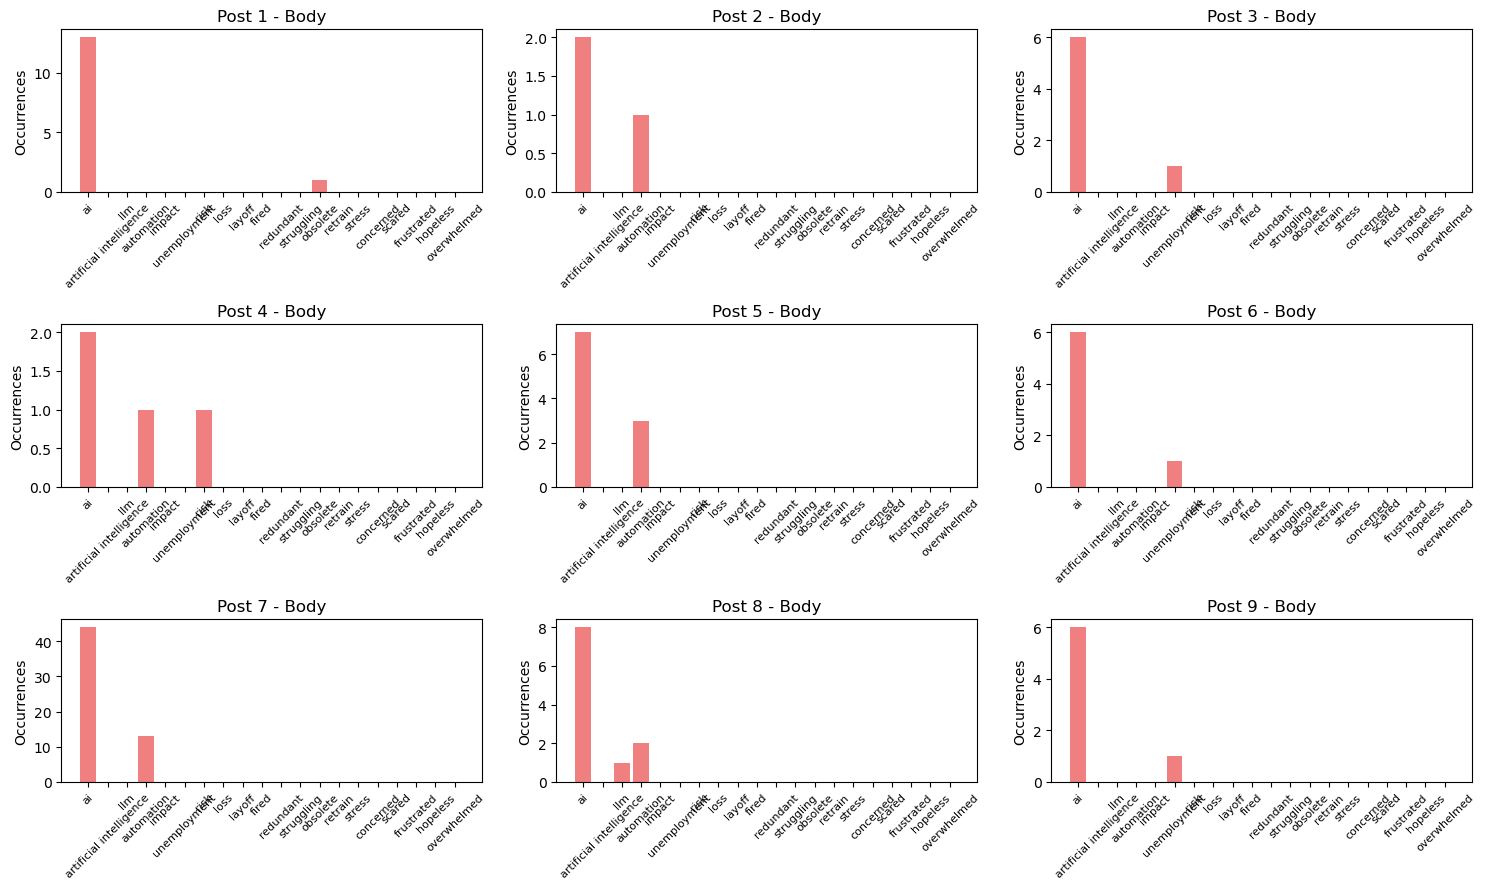

In [30]:
# Function to count key term occurrences in each post
def count_terms(text_column):
    term_counts = []
    
    for text in df[text_column].astype(str):
        word_count = {term: text.lower().count(term) for term in key_terms}
        term_counts.append(word_count)
    
    return term_counts

# Get frequency counts for Titles and Post Bodies
title_counts = count_terms('Title')
body_counts = count_terms('Selftext')

title_df = pd.DataFrame(title_counts)
body_df = pd.DataFrame(body_counts)

title_df.fillna(0, inplace=True)
body_df.fillna(0, inplace=True)

# Set up grid dimensions
num_posts = min(9, len(df))  
num_cols = 3
num_rows = (num_posts // num_cols) + (num_posts % num_cols > 0)

# Grid for bar titles
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i in range(num_posts):
    axes[i].bar(key_terms, title_df.iloc[i], color='skyblue')
    axes[i].set_title(f"Post {i+1} - Title")
    axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
    axes[i].set_ylabel("Occurrences")

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Grid for bar post bodies 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i in range(num_posts):
    axes[i].bar(key_terms, body_df.iloc[i], color='lightcoral')
    axes[i].set_title(f"Post {i+1} - Body")
    axes[i].set_xticklabels(key_terms, rotation=45, fontsize=8)
    axes[i].set_ylabel("Occurrences")

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

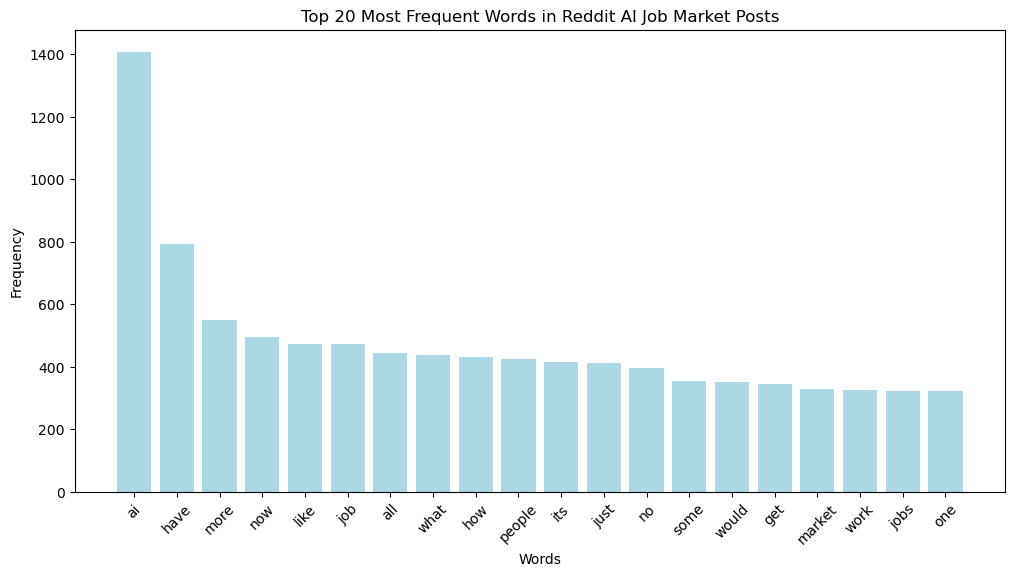

In [31]:
# Drop missing values in "Title" and "Selftext"
df = df.dropna(subset=['Title', 'Selftext'])

# Combine all text from both columns ("Title" + "Selftext")
all_text = " ".join(df['Title'].astype(str) + " " + df['Selftext'].astype(str)).lower()


clean_text = re.sub(r'[^a-z\s]', '', all_text)

words = clean_text.split()

stop_words = set([
    "the", "and", "to", "of", "in", "for", "with", "on", "at", "by", 
    "an", "a", "as", "is", "this", "that", "are", "it", "from", "be", 
    "or", "was", "were", "has", "had", "not", "but", "they", "you", "we",
    "i", "my", "will", "your", "about", "can", "if", "their", "do", "so"
])

filtered_words = [word for word in words if word not in stop_words]

# Count word occurrences
word_frequencies = Counter(filtered_words)


top_words = word_frequencies.most_common(20)


top_word_labels, top_word_counts = zip(*top_words)


plt.figure(figsize=(12, 6))
plt.bar(top_word_labels, top_word_counts, color='lightblue')

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Reddit AI Job Market Posts")
plt.xticks(rotation=45)

plt.show()